In [1]:
import os
import sys
p = os.path.dirname(os.path.abspath('../algo-trading'))
sys.path.append(p)

os.chdir('../')
print(os.getcwd())

/Users/benjaminsmith/Developer/algo-trading


In [2]:
import pandas as pd
import numpy as np
from pandas_datareader import data as web
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from common.database import QueryDatabase, GetTable

In [278]:
symbols = QueryDatabase("""SELECT distinct(symbol), max(h), min(l), count(*) 
FROM finnhub_stock_candles_1 
WHERE symbol IN (SELECT symbol FROM finnhub_stock_symbols WHERE "type"='Common Stock')
GROUP BY 1 ORDER BY 2 DESC""")
symbols

[('CAR', 545.11, 34.25, 92186),
 ('GNRC', 524.23, 202.56, 76101),
 ('CRL', 460.21, 230.48, 53813),
 ('SAIA', 366.0, 171.16, 40613),
 ('GLOB', 354.575, 173.37, 45701),
 ('DOCU', 314.7, 131.0, 113079),
 ('ICUI', 282.0, 183.39, 26600),
 ('ROG', 273.0, 146.02, 21923),
 ('COHR', 271.0, 119.34, 41019),
 ('NVCR', 265.65, 78.01, 69799),
 ('CHDN', 262.2, 175.49, 43045),
 ('SITE', 259.12, 130.82, 48613),
 ('KNSL', 252.565, 153.12, 28640),
 ('ROLL', 250.52, 163.32, 24003),
 ('NXPI', 239.91, 152.93, 102116),
 ('LGND', 219.77, 82.25, 34710),
 ('NDAQ', 214.69, 119.76, 84777),
 ('ZG', 212.4, 52.11, 75807),
 ('Z', 208.1, 52.6, 107386),
 ('NTLA', 202.51, 35.69, 86010),
 ('SAFM', 199.99, 125.55, 37820),
 ('IRBT', 197.4, 65.1, 65610),
 ('FIZZ', 196.43, 41.63, 55545),
 ('ANAT', 195.89, 84.51, 15652),
 ('MTCH', 182.0, 120.91, 99428),
 ('SRPT', 181.83, 65.3, 82751),
 ('KRNT', 181.38, 64.48, 46692),
 ('RARE', 179.63, 72.89, 59505),
 ('EVBG', 178.73, 57.58, 61369),
 ('KOSS', 173.99, 2.145, 55883),
 ('ZEN', 16

In [300]:
from data_etl.dollar_bars import GetBars

bars = GetBars('NXPI', sample_factor=1/60, resolution=1, bar_type='volume')

2021-12-15 15:48:04,096 DEBUG    reparsing 102116 bars with 686822392 total volume such that new bars have 403554.2277410005 quantity each.


In [301]:
bars['c_log'] = np.log2(bars['c'])
max_ = max(bars['c_log'])
min_ = min(bars['c_log'])
quantile = (max_ - min_) / 12

In [302]:
# calculate konto entropy over the log of close prices, using moving windowed words.
from features.entropy import konto

bars['char'] = np.floor((bars['c_log'] - min_) / quantile) + 97

data = ''
res = None
entropy = []
for i, val in bars['char'].iteritems():
    data += chr(int(val))
    
    if len(data) >= 32:
        res = konto(data) #, memory=res)

        entropy.append(res['r'])
        
        data = data[1:]
entropy = [entropy[0]]*32 + entropy

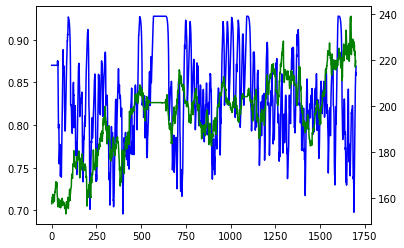

In [303]:
plt.plot(entropy, 'b')
plt.twinx()
plt.plot(bars['c'], 'g')
plt.show()

In [304]:
# split the log of close prices into the impulse and the noise, then calculate konto entropy on the noise
from features.fracdiff import fracDiff_FFD

d = 0.35
ffd = fracDiff_FFD(bars[['c_log']], d, thres=1.0/len(bars))

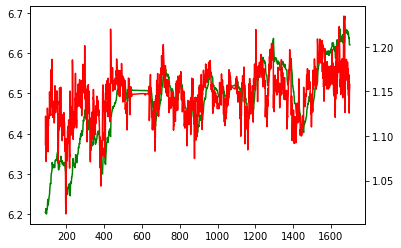

In [305]:
plt.plot(bars['c_log']-ffd['c_log'], 'g')
plt.twinx()
plt.plot(ffd['c_log'], 'r')
plt.show()

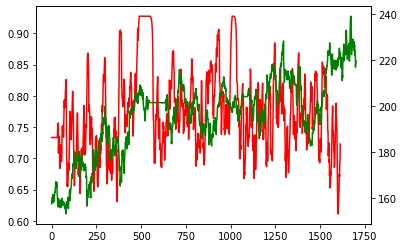

In [306]:
min_ = min(ffd['c_log'])
max_ = max(ffd['c_log'])
quantile = (max_ - min_) / 10.0
chars = np.floor((ffd['c_log'] - min_) / quantile) + 97.0

data = ''
res = None
entropy = []
for i, val in chars.iteritems():
    data += chr(int(val))
    
    if len(data) >= 32:
        res = konto(data) #, memory=res)

        entropy.append(res['r'])
        
        data = data[1:]
        
entropy = [entropy[0]] * 32 + entropy
plt.plot(entropy, 'r')
plt.twinx()
plt.plot(bars['c'], 'g')
plt.show()

In [307]:
# test for stationarity with Augmented Dickey-Fuller
from statsmodels.tsa.stattools import adfuller
result = adfuller(ffd['c_log'])

In [308]:
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.078756
p-value: 0.000015
Critical Values:
	1%: -3.434
	5%: -2.863
	10%: -2.568


In [333]:
def calcADFull(Y):
    X = np.split(Y[:len(Y) - len(Y)%LEN], np.floor(len(Y)/LEN))

    adfull = []
    for i in range(1, len(X)):
        result = adfuller(np.concatenate((X[i-1],X[i])))
        adfull.append({'stat': result[0], 'p': result[1], 'one_percent': result[4]['1%'], 'idx': (i+1)*len(X[i])+len(X[0])*2})
        
    adfull = pd.DataFrame(adfull)
    # scale up the index to plot against prices
    adfull.index = adfull['idx']
    # adfull.index = np.floor(adfull.index / max(adfull.index) * (max(ffd.index)-LEN*2)) + LEN * 2
    return adfull

In [334]:
LEN = 20
Y = (bars['c_log']-ffd['c_log']).dropna() 
adfull = calcADFull(Y)
#Y = ffd['c_log']

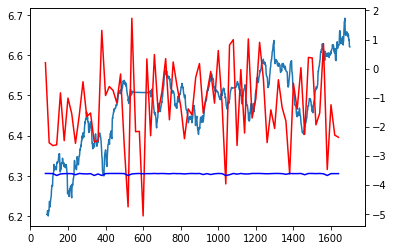

In [335]:
# with overlapping 16 or 32 segments on the ffd data it seems to be able to identify entry/exit of informed traders
# 
plt.plot(Y)
plt.twinx()
plt.plot(adfull['stat'], 'r')
plt.plot(adfull['one_percent'], 'b')
plt.show()

plt.plot(bars['c'])
plt.twinx()

plt.plot(adfull['p'], 'b')
plt.show()

In [336]:
LEN = 20
Y = ffd['c_log']
adfull = calcADFull(Y)

In [337]:
plt.plot(Y)
plt.twinx()
plt.plot(adfull['stat'], 'r')
plt.plot(adfull['one_percent'], 'b')
plt.show()

plt.plot(bars['c'])
plt.twinx()

plt.plot(adfull['p'], 'b')
plt.show()